In [3]:
import numpy as np
import pandas as pd
import os

In [4]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import math

import warnings
warnings.filterwarnings("ignore")

In [5]:
def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="Real Natural Gas price")
    plt.plot(predicted, color="blue", label="Predicted Natural Gas price")
    plt.title("Natural Gas price prediction")
    plt.xlabel("Time")
    plt.ylabel("NG price")
    plt.legend()
    plt.show()

In [6]:
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [7]:
data = pd.read_csv(r'C:/Users/yaman/OneDrive/Documents/Projects 2023/Data Mining/Data.csv', index_col='Date', parse_dates=["Date"])

In [8]:
data.shape

(2961, 6)

In [9]:
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2011-12-14,171.9,175.4,176.2,171.4,46.51K,2.50%
2011-12-15,168.9,171.6,172.0,167.1,70.29K,-1.75%
2011-12-16,165.4,168.4,168.4,163.5,52.03K,-2.07%
2011-12-17,165.8,166.0,166.0,165.0,1.68K,0.24%
2011-12-19,165.5,165.2,165.9,162.5,35.44K,-0.18%
...,...,...,...,...,...,...
2022-12-26,434.1,430.0,437.0,422.2,3.45K,0.86%
2022-12-27,429.1,436.5,439.7,421.0,7.06K,-1.15%
2022-12-28,385.2,419.4,419.4,377.2,68.12K,-10.23%


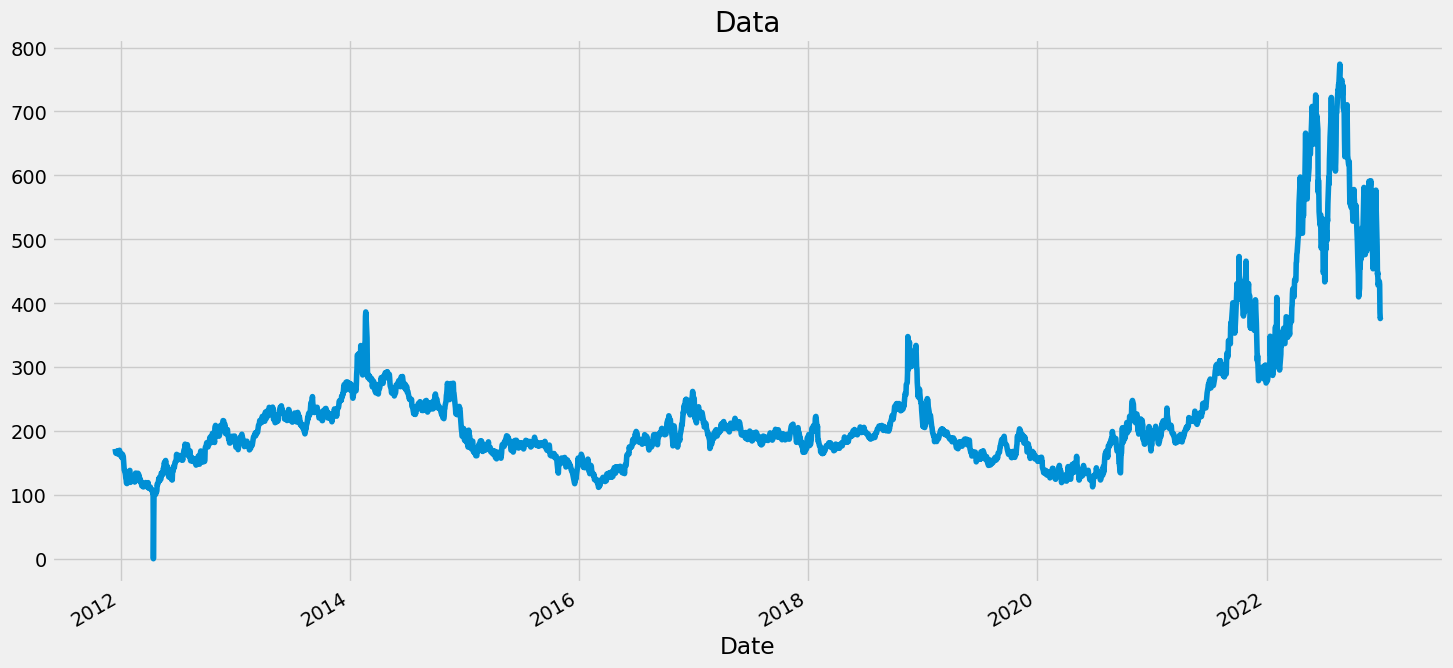

In [10]:
data["Price"].plot(figsize=(16,8))
plt.title("Data")
plt.show()

In [11]:
train = data[:'2019-07-18'].iloc[:,1:2].values
test = data['2019-07-19':].iloc[:,1:2].values

In [12]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

In [13]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements

x_train = []
y_train = []

for i in range(60,2072):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [14]:
x_train[0]

array([0.2640056 , 0.25070028, 0.2394958 , 0.23109244, 0.22829132,
       0.23109244, 0.22759104, 0.23669468, 0.23179272, 0.22934174,
       0.22864146, 0.22584034, 0.24509804, 0.24194678, 0.22093838,
       0.21568627, 0.21498599, 0.21498599, 0.20973389, 0.2254902 ,
       0.20413165, 0.2202381 , 0.21778711, 0.20798319, 0.18067227,
       0.1495098 , 0.13620448, 0.13130252, 0.12710084, 0.10784314,
       0.09033613, 0.08753501, 0.06337535, 0.06302521, 0.06022409,
       0.08718487, 0.10154062, 0.12815126, 0.12394958, 0.13410364,
       0.13130252, 0.08473389, 0.06827731, 0.08648459, 0.07773109,
       0.07598039, 0.08578431, 0.07633053, 0.07843137, 0.08193277,
       0.08403361, 0.08088235, 0.07352941, 0.09033613, 0.07142857,
       0.09278711, 0.11764706, 0.11554622, 0.10364146, 0.10434174])

In [15]:
y_train[0]

0.09908963585434177

In [16]:
len(x_train)

2012

In [17]:
len(y_train)

2012

In [18]:
x_train.shape

(2012, 60)

In [19]:
y_train.shape

(2012,)

In [20]:
# reshaping x_train for efficient modelling

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [21]:
x_train.shape

(2012, 60, 1)

In [102]:
# LSTM architecture

regressor = Sequential()

# add first layer with dropout

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.2))

# add second layer

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add third layer

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add fourth layer

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# the output layer

regressor.add(Dense(units=1))
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_14 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 50)               

In [110]:
# compiling the model

regressor.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# fitting the model

regressor.fit(x_train, y_train, epochs=5, batch_size=150)

Epoch 1/5
14/14 [==============================] - 34s 560ms/step - loss: 0.0180
Epoch 2/5
14/14 [==============================] - 8s 557ms/step - loss: 0.0173
Epoch 3/5
14/14 [==============================] - 8s 534ms/step - loss: 0.0152
Epoch 4/5
14/14 [==============================] - 7s 526ms/step - loss: 0.0134
Epoch 5/5
14/14 [==============================] - 7s 504ms/step - loss: 0.0104


In [111]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 'High' attribute data for processing

dataset_total = pd.concat((data['Price'][:'2019-07-18'], data['Price']['2019-07-19':]), axis=0)
print(dataset_total.shape)

inputs = dataset_total[len(dataset_total)-len(test)-60 : ].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)
print(inputs.shape)

(2961,)
(949,)
(949, 1)
(949, 1)


In [112]:
# preparing x_test

x_test = []
for i in range(60,949):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [113]:
# predicting the stock prices for test set

predicted = regressor.predict(x_test)
predicted = sc.inverse_transform(predicted)

28/28 [==============================] - 4s 54ms/step


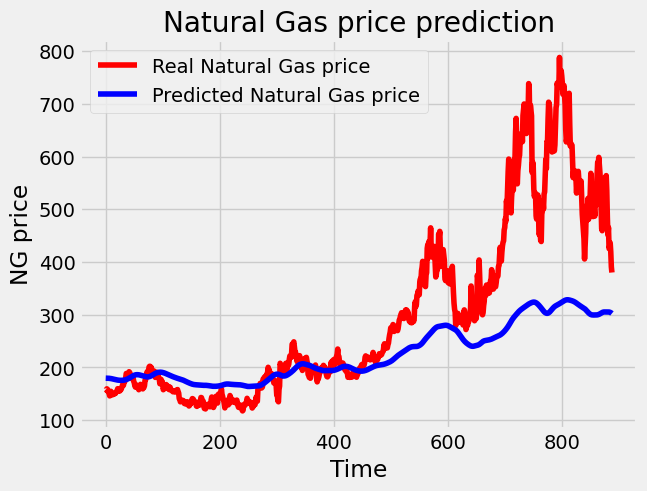

In [114]:
# visualizing the results: predicted vs test

plot_predictions(test, predicted)

In [115]:
return_rmse(test, predicted)

the root mean squared error is : 138.80961775410458.


In [116]:
mean_absolute_percentage_error(test, predicted)

0.2278395755611536